# Explore here

In [37]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
import pandas as pd
from imblearn.metrics import specificity_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from random_forest_custom_models import RandomForestBootstrap

Loading the pre-processed data frame

In [38]:
df = pd.read_csv('/workspaces/JMT1ST-BOOSTING-ALG/data/processed/knn_imputed_diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0.0
764,2.0,122.0,70.0,27.0,165.0,36.8,0.340,27.0,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0.0
766,1.0,126.0,60.0,35.2,134.2,30.1,0.349,47.0,1.0


As we have an already cleaned df we can generate the Boosting 

In [39]:
#Splitting the data 

X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
#Homemade boosting following class method
class CustomBoosting:

    def __init__(self, n_estimators=100, learning_rate=0.01, max_depth=10, 
                 min_samples_leaf=10, max_features=1.0, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.estimators = []

    def sample(self, X, y, weights):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)

        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), len(X), p=weights)
        return X.iloc[indices], y.iloc[indices]

    def compute_error(self, y_true, y_pred, weights):
        misclassified = (y_pred != y_true)
        weighted_error = np.sum(weights[misclassified]) / np.sum(weights)
        return misclassified, weighted_error

    def compute_estimator_weight(self, weighted_error):
        weighted_error = np.clip(weighted_error, 1e-10, 1 - 1e-10)
        return self.learning_rate * np.log((1 - weighted_error) / weighted_error)

    def update_weights(self, estimator_weight, misclassified, weights):
        adjustment = np.where(misclassified, np.exp(estimator_weight), np.exp(-estimator_weight))
        weights *= adjustment
        weights /= np.sum(weights)
        return weights

    def fit(self, X, y):
        weights = np.ones(len(X)) / len(X)
        for _ in range(self.n_estimators):
            X_sampled, y_sampled = self.sample(X, y, weights)
            estimator = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            ).fit(X_sampled, y_sampled)

            y_pred = estimator.predict(X)
            misclassified, weighted_error = self.compute_error(y, y_pred, weights)
            estimator_weight = self.compute_estimator_weight(weighted_error)
            self.estimators.append((estimator, estimator_weight))
            weights = self.update_weights(estimator_weight, misclassified, weights)

    def predict(self, X):
        final_score = np.zeros(X.shape[0])
        for estimator, weight in self.estimators:
            final_score += weight * estimator.predict(X)
        return np.where(final_score >= 0, 1, 0)

    def predict_proba(self, X):
        final_score = np.zeros(X.shape[0])
        for estimator, weight in self.estimators:
            final_score += weight * estimator.predict(X)
        probs = 1 / (1 + np.exp(-final_score))
        return np.vstack([1 - probs, probs]).T


In [41]:
#Converting train/test sets to NumPy arrays before passing them into the class (Solution from internet)
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [42]:
#Training the model
boost_model = CustomBoosting(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=5,
    max_features=1.0,
    random_state=42
)

boost_model.fit(X_train, y_train)

In [43]:
#Predictions
y_pred = boost_model.predict(X_test)
y_proba = boost_model.predict_proba(X_test)[:, 1]

train_pred = boost_model.predict(X_train)
test_pred = boost_model.predict(X_test)

In [44]:
#Getting the metrics following class method

def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    #Train metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    #Test metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    #Differences
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    #Combine into DataFrame
    metrics_df = pd.DataFrame(
        [[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],
         [test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],
         [diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
        columns=['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
        index=['Train', 'Test', 'Difference']
    )

    return metrics_df


In [45]:
#Metrics
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.348534,0.516908,0.5,0.348534,1.0,0.0
Test,0.350649,0.519231,0.5,0.350649,1.0,0.0
Difference,-0.002115,-0.002323,0.0,-0.002115,0.0,0.0


These results show that the model's performance on both the training and test sets is very similar, with almost no difference in accuracy, F1 score, precision, recall, and specificity. However, the overall accuracy and precision are quite low (~35%), and the AUC of 0.5 indicates the model is performing no better than random guessing. The recall of 1.0 paired with specificity of 0 suggests the model predicts the positive class for nearly all instances, leading to poor discrimination between classes. This implies the model is severely imbalanced or biased and needs significant improvement whhich we will be doing by tuning the hyperparameters

In [46]:
#Tuning hyperparameters following class method

#hyperparameter ranges
n_estimators_list = [10, 50, 100, 200, 300]
learning_rate_list = [0.001, 0.01, 0.1, 0.2, 0.5]
max_depth_list = [2, 3, 5, 7, 10, 15]
min_samples_leaf_list = [1, 2, 5, 10]
max_features_list = [0.3, 0.5, 0.7, 1.0]

max_trials = 50
count = 0

results = []

#Looping over all combinations with trial limit
for n_estimators, learning_rate, max_depth, min_samples_leaf, max_features in itertools.product(
    n_estimators_list, learning_rate_list, max_depth_list, min_samples_leaf_list, max_features_list):

    if count >= max_trials:
        break

    print(f"Training with n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, "
          f"min_samples_leaf={min_samples_leaf}, max_features={max_features}")

    clf = CustomBoosting(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    
    clf.fit(X_train, y_train)
    
    y_pred_test = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'test_accuracy': test_acc
    })

    count += 1

#DataFrame
results_df = pd.DataFrame(results)


Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=1, max_features=0.3
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=1, max_features=0.5
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=1, max_features=0.7
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=1, max_features=1.0
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=2, max_features=0.3
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=2, max_features=0.5
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=2, max_features=0.7
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=2, max_features=1.0
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=5, max_features=0.3
Training with n_estimators=10, learning_rate=0.001, max_depth=2, min_samples_leaf=

In [47]:
results_df.sort_values(by="test_accuracy", ascending=False).head(10)

,n_estimators,learning_rate,max_depth,min_samples_leaf,max_features,test_accuracy
0,10,0.001,2,1,0.3,0.350649
1,10,0.001,2,1,0.5,0.350649
2,10,0.001,2,1,0.7,0.350649
3,10,0.001,2,1,1.0,0.350649
4,10,0.001,2,2,0.3,0.350649
5,10,0.001,2,2,0.5,0.350649
6,10,0.001,2,2,0.7,0.350649
7,10,0.001,2,2,1.0,0.350649
8,10,0.001,2,5,0.3,0.350649
9,10,0.001,2,5,0.5,0.350649


In [48]:
#Looking for the best config of hyperparameters
best_config = results_df.sort_values(by="test_accuracy", ascending=False).iloc[0]
print("Best Configuration:")
print(best_config)

Best Configuration:
n_estimators        10.000000
learning_rate        0.001000
max_depth            2.000000
min_samples_leaf     1.000000
max_features         0.300000
test_accuracy        0.350649
Name: 0, dtype: float64


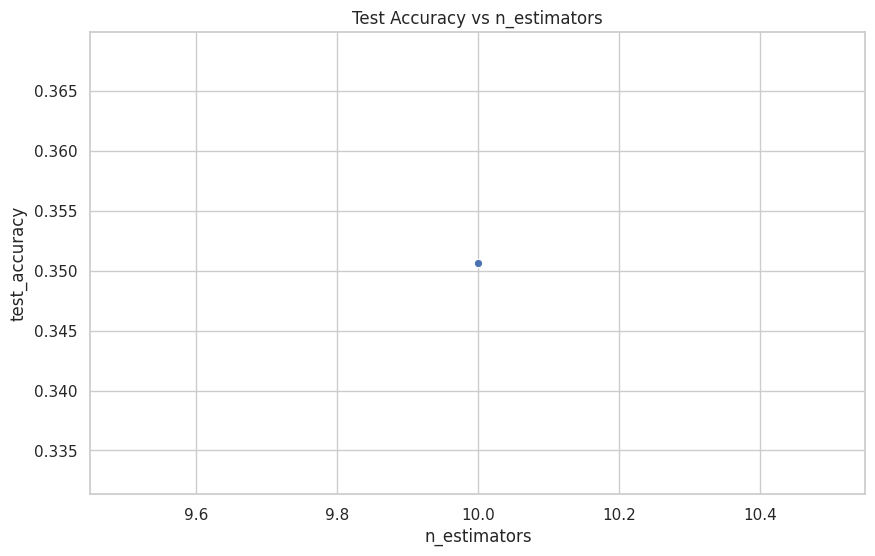

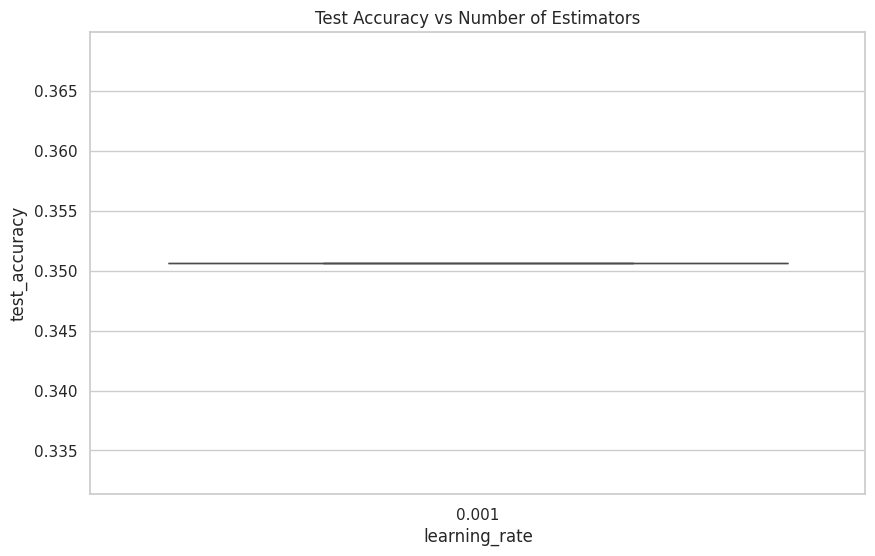

<Figure size 640x480 with 0 Axes>

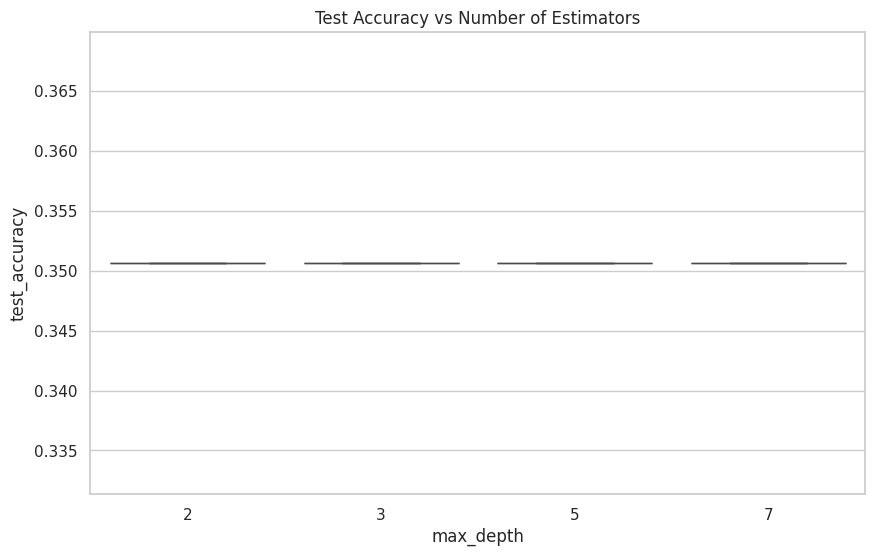

<Figure size 640x480 with 0 Axes>

In [49]:
#Visualization for better understanding
sns.set_theme(style="whitegrid")

#Plots
plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x='n_estimators', y='test_accuracy', marker='o')
plt.title('Test Accuracy vs n_estimators')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="learning_rate", y="test_accuracy", data=results_df)
plt.title("Test Accuracy vs Number of Estimators")
plt.show()
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.boxplot(x="max_depth", y="test_accuracy", data=results_df)
plt.title("Test Accuracy vs Number of Estimators")
plt.show()
plt.tight_layout()

The hyperparameter tuning results show that the best model configuration achieves a test accuracy of approximately 0.351 with relatively low values for all parameters: 10 estimators, learning rate 0.001, max depth of 2, minimum samples per leaf of 1, and max features set to 0.3. Across all tested combinations, the test accuracy remains consistently around 0.35, as reflected by the flat lines in the various performance plots.

In [50]:
#Saving the model 

#Final CustomBoosting model with best hyperparameters
final_boost = CustomBoosting(
    n_estimators=10,
    learning_rate=0.001,
    max_depth=2,
    min_samples_leaf=1,
    max_features=0.3,
    random_state=42
)

# Fit the model with training data
final_boost.fit(X_train, y_train)


In [51]:
#Joblib saving
joblib.dump(final_boost, '/workspaces/JMT1ST-BOOSTING-ALG/models.pkl')

['/workspaces/JMT1ST-BOOSTING-ALG/models.pkl']

Now for the final part of the project we will be performing a comparison between the three models (Decision Tree, Random Forest and Boosting), analyze the metrics and selecting one model as the best one.

In [52]:
#Loading the models

#In order to get the random forest models I had to create a new folder in that project root, extract the class with imports, download that file into my pc
#and then upload that file in this project importing the class as if it was a method from any library

#Models
decision_tree_models = joblib.load("/workspaces/JMT1ST-BOOSTING-ALG/models/decision_tree_models.pkl")
random_forest_models = joblib.load("/workspaces/JMT1ST-BOOSTING-ALG/models/random_forest_model.pkl")
boosting_alg_model = joblib.load("/workspaces/JMT1ST-BOOSTING-ALG/models/boosting_alg_models.pkl")

/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [53]:
#Ppredictions
dt_preds = decision_tree_models.predict(X_test)
rf_preds = random_forest_models.predict(X_test.values)
boost_preds = boosting_alg_model.predict(X_test)

In [54]:
#Saving and converting results to a df 
models_preds = {
    "Decision Tree": dt_preds,
    "Random Forest": rf_preds,
    "Boosting": boost_preds
}

results = {}

for model_name, preds in models_preds.items():
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision (Macro)": report['macro avg']['precision'],
        "Recall (Macro)": report['macro avg']['recall'],
        "F1-score (Macro)": report['macro avg']['f1-score']
    }

results_df = pd.DataFrame(results).T

results_df

,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro)
Decision Tree,0.831169,0.813776,0.818889,0.816162
Random Forest,0.740260,0.719079,0.685000,0.693776
Boosting,0.350649,0.175325,0.500000,0.259615



Let's clarify this dataframe results with a visual interpretation

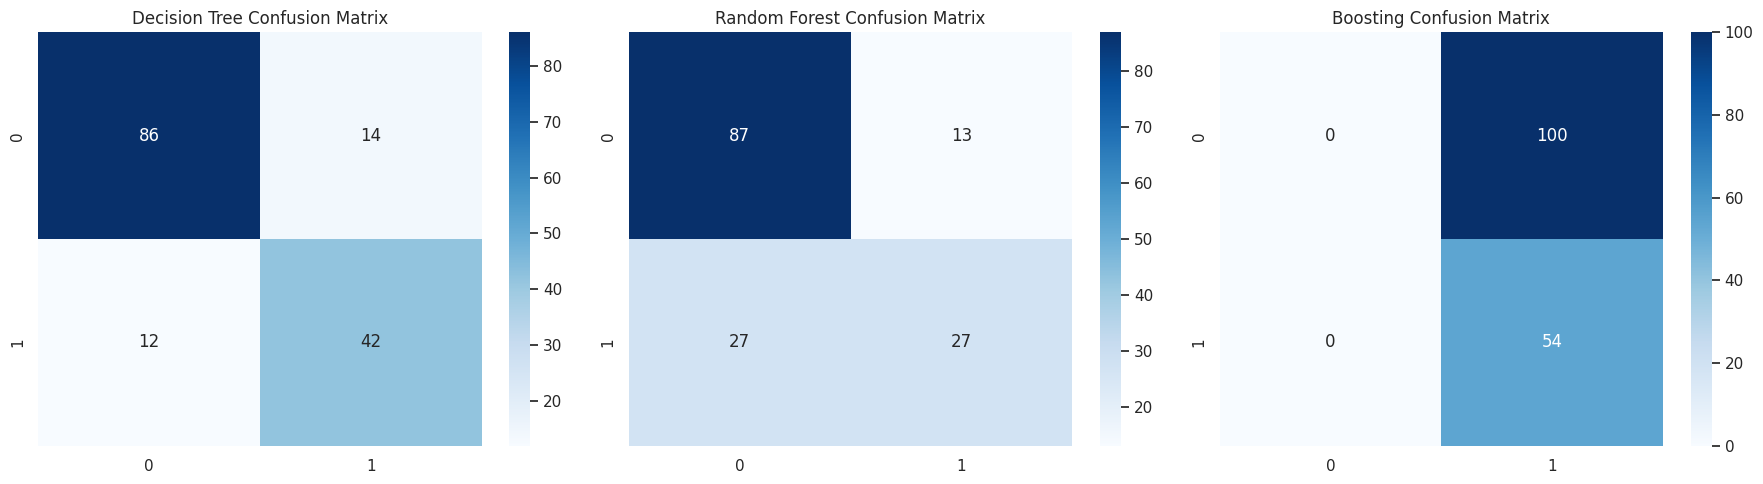

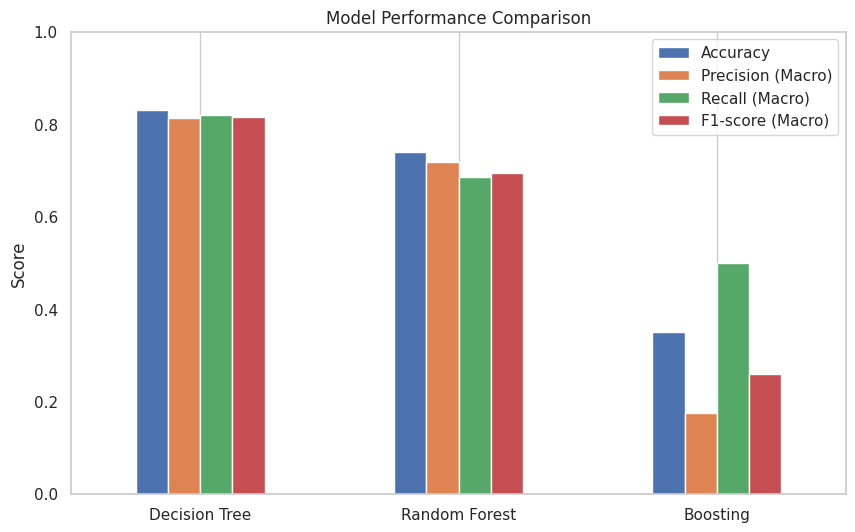

In [55]:
#Models definition
models = {
    "Decision Tree": dt_preds,
    "Random Forest": rf_preds,
    "Boosting": boost_preds
}

metrics = ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-score (Macro)"]

#CFM
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model_name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.show()

#Grouped bar chart
results_df[metrics].plot(kind='bar', figsize=(10,6), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()


As we can see, the Decision Tree model performs best overall, with high accuracy (83%) and balanced precision and recall around 81%, indicating reliable and consistent predictions. The Random Forest model shows moderate performance but is noticeably worse than the Decision Tree. The Boosting model performs poorly, with very low accuracy (35%) and precision (17%). Overall, the Decision Tree is the most trustworthy model based on these results.

Decision Tree is the best-performing and preferred model.

NOTE:

For the past three projects, I followed the class approach by building "homemade" versions of each algorithm replicating previous class methods to try to better understand how they work internally. However, I often found myself stuck, especially when trying to compute evaluation metrics and tune hyperparameters. I had to rely heavily on frequent, in-depth online research much more than in previous projects. Using built-in library methods would have made the process significantly easier, but I only came to that realization after completing the project (particularly when dealing with importing files for the Random Forest model). I suspect there might be some flaws in the implementation or training of these models, and I understand if the work is not accepted. If that happens, my plan is to revise the projects using standard library methods and more reliable tools for evaluation.